# Exam July 29

Martina Ianaro. ID: 973377

# Task

The purpose of the project is to separate an image obtained as a sum of a two images into its components.

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2.

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow import keras as ks
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

import numpy as np
from matplotlib import pyplot as plt

# Dataset Creation
Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32)

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


## The Datagenerator

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data 

In [ ]:
batch_sz = 64

 Training and Testing datagenerator

In [ ]:
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train,batch_sz)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test,batch_sz)

 # Model

## Internal Methods

In [ ]:
#Conv block consists of a convolution layer with ReLU
def conv_block(x, filter_size, size, dropout, batch_norm=False):
  
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv
    

# lambda function to repeat Repeats the elements of a tensor along an axis by a factor of rep.
def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


#Residual convolutional layer.
def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
 
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    #Activation after addition with shortcut
    res_path = layers.Activation('relu')(res_path)    
    return res_path


#resize the down layer feature map into the same dimension as the up layer feature map using 1x1 conv
def gating_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    #x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    #gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


Build the model method

In [ ]:
#Rsidual UNet, with attention 
def a_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True, FILTER_NUM= 64):# number of basic filters for the first layer
    
    # network structure
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)


    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    gating_32 = gating_signal(conv_16, 8*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)
    conv_difference = 2*inputs - conv_final
    conv_concat = layers.concatenate([conv_difference, conv_final], axis = 2)

    # Model integration
    model = models.Model(inputs, conv_concat, name="a_RsUNet")
    return model

In [ ]:
input_shape = (32,32,1)
a_RsUNet_model = a_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)
a_RsUNet_model.summary()

Model: "a_RsUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0

Build the Attention Res UNet.
Adam as optimizer and set as metrics the mse.
Print the summary of the model

In [ ]:
callback_checkpoint = ModelCheckpoint('a_RsUNet_model.{epoch:02d}-{val_loss:.6f}.hdf5', save_weights_only=True) 
#Configures the model for training with optimizer Adam and as Loss function Mean Squared error
a_RsUNet_model.compile(optimizer=Adam(), loss='mse')

## Settings parameters

In [ ]:
N_train, w, h = mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2]
N_test = mnist_x_test.shape[0] 
stpepoch = 10000 #steps per epochs,increasing it to avoid overfitting
vlsteps = N_test // batch_sz #validation steps

Trains the model for a fixed number of epochs.
The history object returned by the fit method of model.

In [ ]:
hst = a_RsUNet_model.fit(train_generator,
                                   epochs=20,
                                   batch_size=batch_sz,
                                   validation_data=test_generator,
                                   callbacks=[callback_checkpoint],
                                   steps_per_epoch=stpepoch,
                                   validation_steps=vlsteps)#Data on which to evaluate the loss and any model metrics at the end of each epoch

Epoch 1/20
10000/10000 [==============================] - 621s 58ms/step - loss: 6.2795e-04 - val_loss: 5.7874e-04
Epoch 2/20
10000/10000 [==============================] - 581s 58ms/step - loss: 5.2334e-04 - val_loss: 4.9547e-04
Epoch 3/20
10000/10000 [==============================] - 581s 58ms/step - loss: 4.7242e-04 - val_loss: 4.4219e-04
Epoch 4/20
10000/10000 [==============================] - 580s 58ms/step - loss: 4.4436e-04 - val_loss: 4.5993e-04
Epoch 5/20
10000/10000 [==============================] - 580s 58ms/step - loss: 4.2452e-04 - val_loss: 4.2917e-04
Epoch 6/20
10000/10000 [==============================] - 580s 58ms/step - loss: 4.0845e-04 - val_loss: 4.3379e-04
Epoch 7/20
10000/10000 [==============================] - 580s 58ms/step - loss: 3.9827e-04 - val_loss: 4.0001e-04
Epoch 8/20
10000/10000 [==============================] - 581s 58ms/step - loss: 3.8660e-04 - val_loss: 3.9357e-04
Epoch 9/20
10000/10000 [==============================] - 580s 58ms/step - loss:

# Test

Try to predict the first image in the test set and then show it compared with the original in the x_test set and the expected solution in the y_test set.

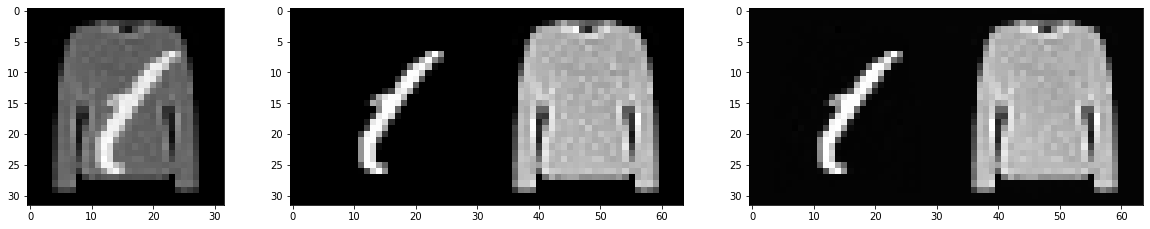

In [ ]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = a_RsUNet_model.predict(x.reshape((1,32,32)))
fig, axs = plt.subplots(1, 3, gridspec_kw={'width_ratios': (1,2,2)}, figsize=(20, 6))
axs[0].imshow(x, cmap='gray', interpolation='nearest')
axs[1].imshow(y, cmap='gray', interpolation='nearest')
axs[2].imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

Repeat computation 10 times and check the Standard deviation (std)

In [ ]:
#Evaluate the mse over 20000 samples randomly generated from the two test_sets
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, 20000)
vect_mse = []#array of mse scores
for i in range(10):#for loop of 10 iterations to compute the mse in a vector
  x_batch, y_batch = next(test_generator)
  mse = a_RsUNet_model.evaluate(x_batch, y_batch)
  vect_mse.append(mse)
print(vect_mse)
print('Min:', min(vect_mse))#minimum of mse values
print('Mean:', np.mean(vect_mse))#mean of mse values in vector
print('Std:', np.std(vect_mse))#standard deviation of mse

625/625 [==============================] - 8s 12ms/step - loss: 3.5510e-04
[0.0003558833268471062, 0.0003571545530576259, 0.000350118731148541, 0.00035718828439712524, 0.00035244569880887866, 0.0003543404454831034, 0.00035208891495130956, 0.00035573181230574846, 0.00034897419391199946, 0.00035509883309714496]
Min: 0.00034897419391199946
Mean: 0.00035390247940085827
Std: 2.7254681044366996e-06


# Overview

The problem is solved considering it as a Segmentaion problem,for which given an image x, classify each pixel of x into one possible class.
It's an Image-to-image maps that are usually implemented as variant of a Fully Convolutional Neural Network design.
Try to use UNet, a convolutional neural network based on the fully convolutional network.
It's a U-shaped structure with  contracting path and expansive path.
Contracting path is a typical convolutional network that consists of repeated application of convolutions, each followed by ReLU and a max pooling operation.
Expansive pathway combines the feature and spatial information through a sequence of up-convolutions and concatenations with high-resolution features from the opposite path.



Residual neural network (ResNet) is an artificial neural network. It is a gateless or open-gated NN working very deep feedforward neural network with hundreds of layers.
ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between.

Attention Mechanism can be implemented as gating functions.
The gating maps are dynamically generated by some NN allowing to focus on different part on the input at different times.
Attention layers are only in expansive pathway and takes 2 inputs.
An input is the gating signal from next lowest layer and due to the fact it comes from deeper part of NN it has a better feature representation. The second input is x that comes from early layers and has bettere spatial information. 

# Second model
First model with some variations:
model with reduced numbers of layers;
epochs increased to 30 in fit method;
method that change automatically the learning rate using ReduceLROnPlateau class.

In [ ]:
#Rsidual UNet with attention

def A_ResUNet_simple(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True, FILTER_NUM= 64):
    # network structure
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    gating_32 = gating_signal(conv_16, 8*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)
    conv_difference = 2*inputs - conv_final
    conv_concat = layers.concatenate([conv_difference, conv_final], axis = 2)


    # Model integration
    model = models.Model(inputs, conv_concat, name="A_ResUNet_simple")
    return model

In [ ]:
input_shape = (32,32,1)
a_ResUNet_model_smp = A_ResUNet_simple(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)
a_ResUNet_model_smp.summary()
callback_checkpoint = ModelCheckpoint('a_ResUNet_model_smp.{epoch:02d}-{val_loss:.6f}.hdf5', save_weights_only=True) 

#ReduceLROnPlateau: reduce learning rate when a metric has stopped improving by a factor of 2-10 once learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor = 0.1,patience = 2,min_delta = 1e-5, min_lr = 1e-6)
a_ResUNet_model_smp.compile(optimizer=Adam(), loss='mse')

Model: "A_ResUNet_simple"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalizat

In [ ]:
N_train, w, h = mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2]
N_test = mnist_x_test.shape[0]

steps_per_epoch = 10000 #increasing the steps_per_epoch to avoid overfitting
val_steps = N_test // batch_sz

hist = a_ResUNet_model_smp.fit(train_generator,
                                   epochs=30,#30 epochs
                                   batch_size=batch_sz,
                                   validation_data=test_generator,
                                   callbacks=[callback_checkpoint,reduce_lr],
                                   steps_per_epoch=steps_per_epoch,
                                   validation_steps=val_steps)

Epoch 1/30
10000/10000 [==============================] - 607s 59ms/step - loss: 0.0067 - val_loss: 7.9868e-04 - lr: 0.0010
Epoch 2/30
10000/10000 [==============================] - 593s 59ms/step - loss: 6.5960e-04 - val_loss: 6.2894e-04 - lr: 0.0010
Epoch 3/30
10000/10000 [==============================] - 592s 59ms/step - loss: 5.3219e-04 - val_loss: 4.8646e-04 - lr: 0.0010
Epoch 4/30
10000/10000 [==============================] - 594s 59ms/step - loss: 4.7871e-04 - val_loss: 4.6012e-04 - lr: 0.0010
Epoch 5/30
10000/10000 [==============================] - 596s 60ms/step - loss: 4.4614e-04 - val_loss: 4.4123e-04 - lr: 0.0010
Epoch 6/30
10000/10000 [==============================] - 592s 59ms/step - loss: 4.2589e-04 - val_loss: 4.6457e-04 - lr: 0.0010
Epoch 7/30
10000/10000 [==============================] - 589s 59ms/step - loss: 4.1124e-04 - val_loss: 4.1829e-04 - lr: 0.0010
Epoch 8/30
10000/10000 [==============================] - 591s 59ms/step - loss: 3.9772e-04 - val_loss: 4.23

#Test
Repeat computation 10 times and check the Standard deviation (std)

In [ ]:
#Evaluate the mse over 20000 samples randomly generated from the two test_sets.
test_gn_2 = datagenerator(mnist_x_test, fashion_mnist_x_test, 20000)
vect_mse = []#array of mse scores
for i in range(10):#for loop of 10 iterations to compute the mse in a vector
  x_batch, y_batch = next(test_gn_2)
  mse = a_ResUNet_model_smp.evaluate(x_batch, y_batch)
  vect_mse.append(mse)
print(vect_mse)
print('Min:', min(vect_mse))#minimum of mse values
print('Mean:', np.mean(vect_mse))#mean of mse values in vector
print('Std:', np.std(vect_mse))#standard deviation of mse

625/625 [==============================] - 8s 12ms/step - loss: 3.4608e-04
[0.00034910719841718674, 0.00034474977292120457, 0.0003495975979603827, 0.0003475983685348183, 0.000343283754773438, 0.00034790203790180385, 0.0003492514370009303, 0.0003473859396763146, 0.00034989710547961295, 0.00034607871202751994]
Min: 0.000343283754773438
Mean: 0.0003474851924693212
Std: 2.081809560726218e-06


The second model has a smallest std value on 20000 samples of text_sets around 2.08 e-06
while the first model has std around 2.72 e-06.

Validation loss.
model 1 val_loss: 3.5610e-04 at epoch 20; 
model 2 val_loss: 3.4412e-04 at epoch 30.

